## Title: Kickstarter success explorations
### Team Members: Connor Bennett, Anghel Carrillo, Kristopher Church

## Introduction:
The crowdfunding platform, Kickstarter, hosts thousands of projects every year, however, not all of them will meet their funding goals. In such cases, the amount of money they raised (referred to as the "amount pledged"), will only be a fraction of the amount asked for (referred to as the "goal amount"). This leads one to wonder, which factors most influence the final ratio between the amount pledged and the goal amount of a kickstarter project. By referencing a ratio, not only will it be possible to know what kinds of kickstarters are likely to succeed, but also to what extent they do or do not. To answer this question, data from April, 2009 to January, 2018 was downloaded from the Kickstarter website, and a machine learning algorithm will be used to designate the factors which the ratio is most determined by.

### TODO:
#### Fine tuning analysis of each block and what our findings are
#### ML: for each algorithm create at least a couple of models
One more supervised algorithm (already used decsion tree for one, but need more models and test to find optimal params)
One more unsupervised if we have time(preprocessign test for feature selection with anomaly detect..?).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree

In [2]:
input_file = 'https://raw.githubusercontent.com/connor-bennett/Proejct-Two/refs/heads/main/kickstarter-projects/ks-projects-201801.csv'
df = pd.read_csv(input_file)

# Explorations

In [3]:
df.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


how many missing values are there?
Fill missing names as Unknown

In [4]:
# Check how many missing values are in each column
print(df.isna().sum()[df.isna().sum() > 0])

# For 'name', decide how to handle missing values
df['name'] = df['name'].fillna('Unknown')  # Replace missing names with 'Unknown'

# What to do with the NAs for 'usd pledged'. How much of the column is it?
print(df['usd pledged'].isna().mean())

# Seems to be 1% of the data, can probably be imputed based on median since its a numerical feature
df['usd pledged'] = df['usd pledged'].fillna(df['usd pledged'].median())
# Could use ML to do predictive imputation instead

# Verify that there are no more missing values
print(df.isna().sum()[df.isna().sum() > 0])

name              4
usd pledged    3797
dtype: int64
0.0100274387908974
Series([], dtype: int64)


## Preprocessing

### Convert dates to datetime

In [5]:
# Convert 'deadline' and 'launched' to datetime if not already
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])

# Verify the data types
print(df.dtypes)


ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object


### what is the going on with pledge/goal and pledge_real/goal_real

In [6]:
# Correlation between usd_goal and usd_goal_real
print(df[['goal', 'usd_goal_real']].corr())

# Check for discrepancies in ratios
df['usd_ratio'] = df['usd_goal_real'] / df['goal']
print(df['usd_ratio'].describe())


                   goal  usd_goal_real
goal           1.000000       0.942692
usd_goal_real  0.942692       1.000000
count    378661.000000
mean          1.022577
std           0.198197
min           0.008757
25%           1.000000
50%           1.000000
75%           1.000000
max           1.714400
Name: usd_ratio, dtype: float64


Above we find that these are very closely correlated. A high correlation of 0.94 indicates that goal and usd_goal_real are strongly related. This suggests that usd_goal_real is likely a more refined version of goal. Futher exploration is required to see if either of these two categories are significant or if they should be removed.

### adding new features and removing uneccessary columns

In [7]:
# Calculate length_of_fundraising
df['length_of_fundraising_days'] = (df['deadline'] - df['launched']).dt.days

# Create the binary success indicator
df['success'] = (df['pledged'] >= df['goal']).astype(int)

#create pledge to funding ratio column
df['pledge_to_goal_ratio'] = (df['pledged'] / df['goal'])

#Remove ID since it has no predictive power
df = df.drop(['ID', 'usd_goal_real', 'usd_pledged_real'], axis=1)

# Verify the new features
print(df[['length_of_fundraising_days','success','pledge_to_goal_ratio']].head())


   length_of_fundraising_days  success  pledge_to_goal_ratio
0                          58        0              0.000000
1                          59        0              0.080700
2                          44        0              0.004889
3                          29        0              0.000200
4                          55        0              0.065795


Is there a significant imbalance in the proportion of kickstarter fundraiser categories?

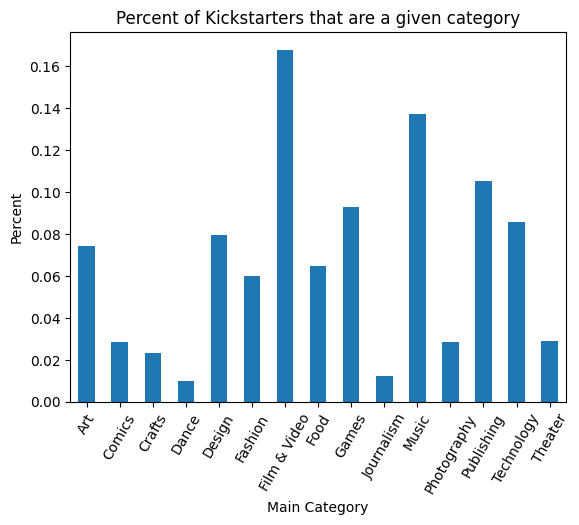

In [8]:
df['main_category'].value_counts(normalize=True).sort_index().plot.bar(rot=60)
plt.title("Percent of Kickstarters that are a given category")
plt.ylabel("Percent")
plt.xlabel("Main Category")
plt.show();

It is clear from the graph above, that some categories are not presented for fundraising as often as others. For example, many fundraisers are centered on Film & Video, but very few are related to Dance. As a hypothesis, perhaps this could reflect a lessened interest in products related to Dance and a greater one for Film & Video. This could mean that Dance kickstarters would be less successful than Film & Video, but so far this is speculation.

Does the length of the fundraiser have an effect on the success rate?

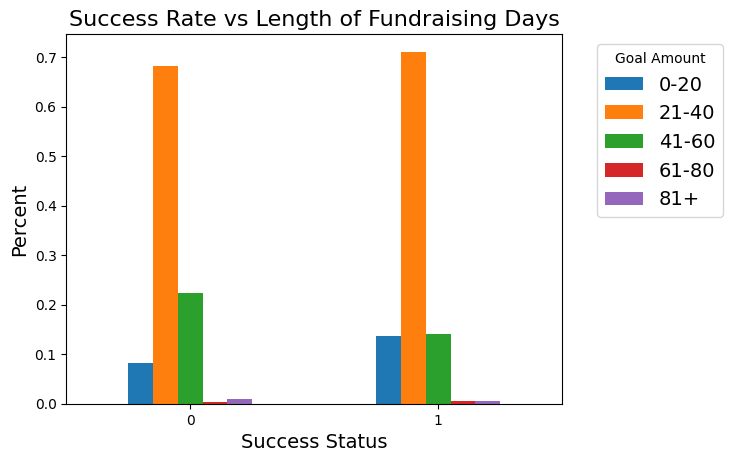

In [9]:
dayBins = [0, 20, 40, 60, 80, np.inf]
dayLabels = ['0-20', '21-40', '41-60', '61-80', '81+']

df['length_of_fund_bins'] = pd.cut(df['length_of_fundraising_days'], bins=dayBins, labels=dayLabels)

ax = pd.crosstab(df['success'], df['length_of_fund_bins'], normalize='index').plot.bar(rot=0);
plt.title('Success Rate vs Length of Fundraising Days', fontsize=16)
plt.xlabel('Success Status', fontsize=14)
plt.ylabel('Percent', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title="Goal Amount");

As can be seen above, the length of the fundraiser seems like it may have a negligeable effect on the fundraiser's success.

## How do dollar funding goals aligns with realized dollar amounts pledged to a project

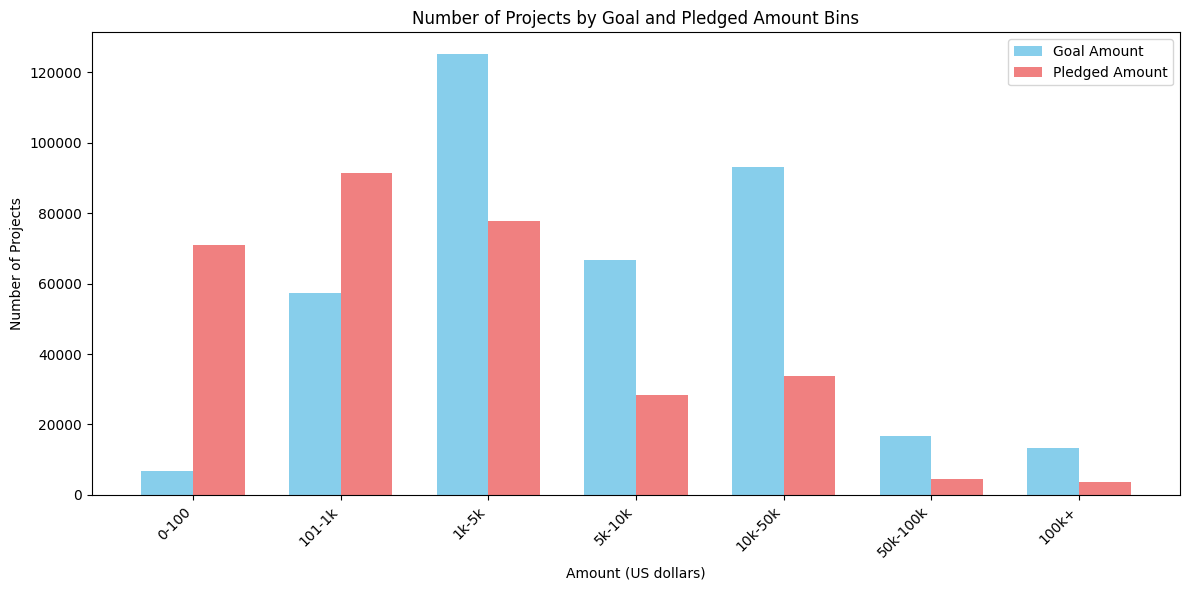

In [10]:
# Step 1: Create bins and labels for both 'goal' and 'usd pledged'
bins = [0, 100, 1000, 5000, 10000, 50000, 100000, np.inf]
labels = ['0-100', '101-1k', '1k-5k', '5k-10k', '10k-50k', '50k-100k', '100k+']

# Add goal_bins and pledged_bins columns to the DataFrame
df['goal_bins'] = pd.cut(df['goal'], bins=bins, labels=labels)
df['pledged_bins'] = pd.cut(df['usd pledged'], bins=bins, labels=labels)

# Step 2: Count the values in each bin
goal_counts = df['goal_bins'].value_counts(sort=False)
pledged_counts = df['pledged_bins'].value_counts(sort=False)

# Step 3: Create a combined bar plot
x = np.arange(len(goal_counts))  # the label locations
width = 0.35  # width of the bars

plt.figure(figsize=(12, 6))

# Plot goal bins
plt.bar(x - width/2, goal_counts, width, label='Goal Amount', color='skyblue')

# Plot pledged bins
plt.bar(x + width/2, pledged_counts, width, label='Pledged Amount', color='lightcoral')

# Add labels, title, and legend
plt.title("Number of Projects by Goal and Pledged Amount Bins")
plt.xlabel("Amount (US dollars)")
plt.ylabel("Number of Projects")
plt.xticks(x, labels=goal_counts.index, rotation=45, ha='right')  # Set x-tick labels and rotate
plt.legend()

# Show the plot
plt.tight_layout()
plt.show();

Earlier we saw that there is a trend that the higher the goal amount, the less likely it is to have its goal met. Is there a connection between this and the category of kickstarter?

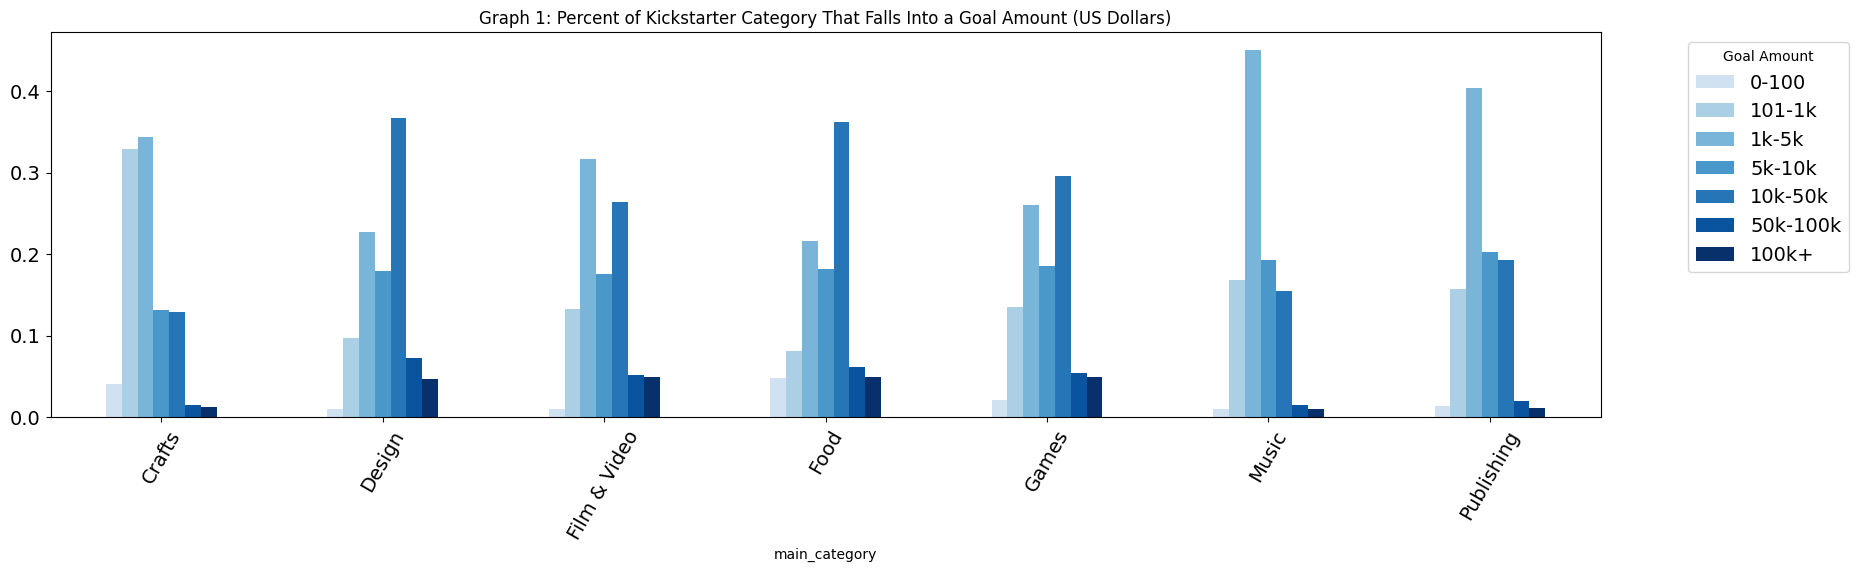

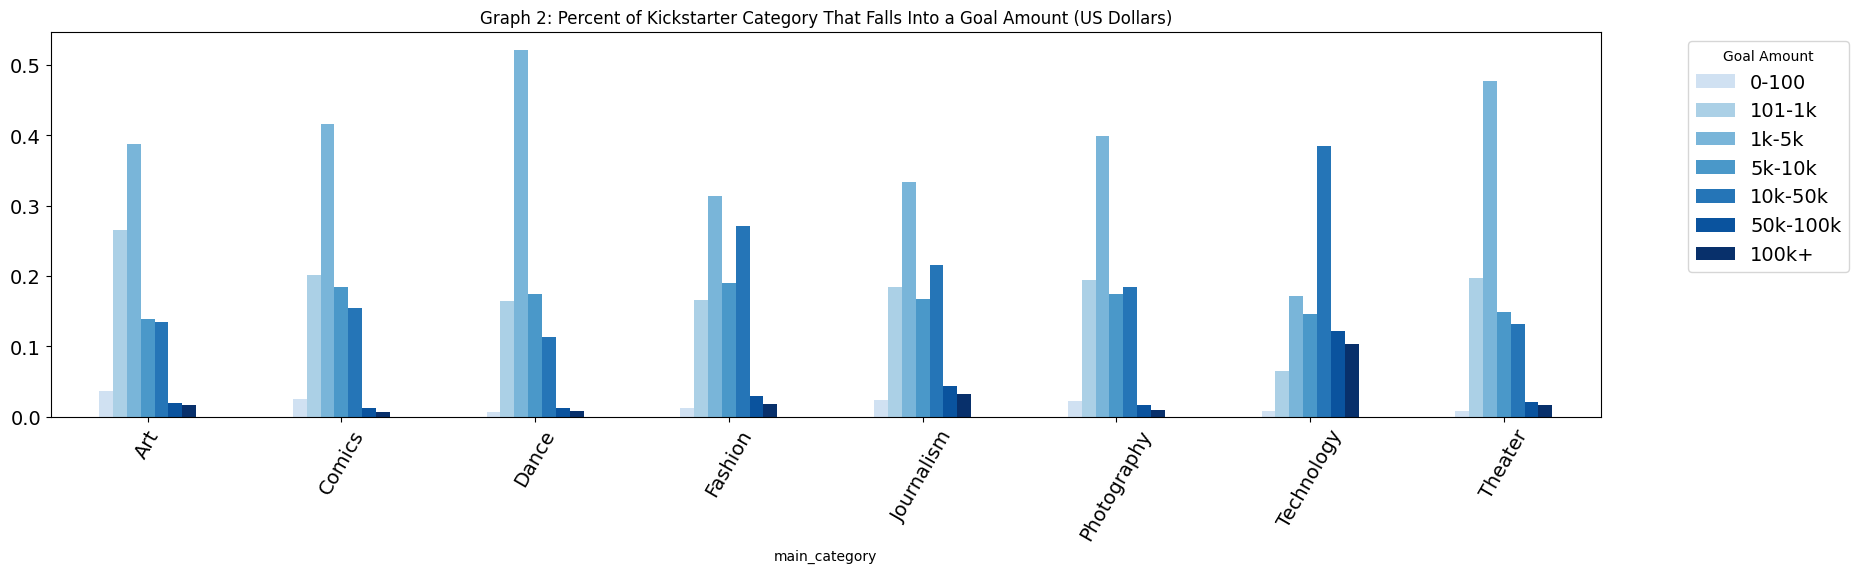

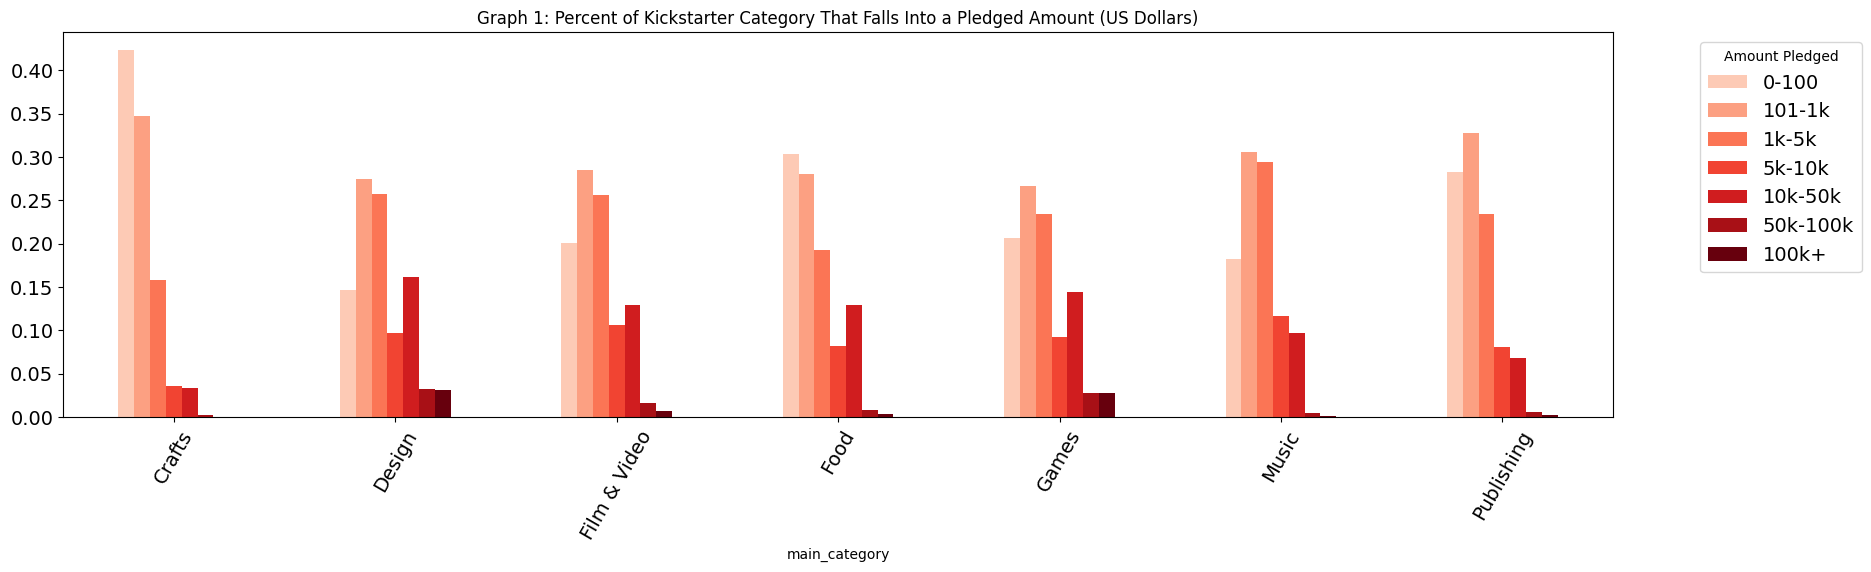

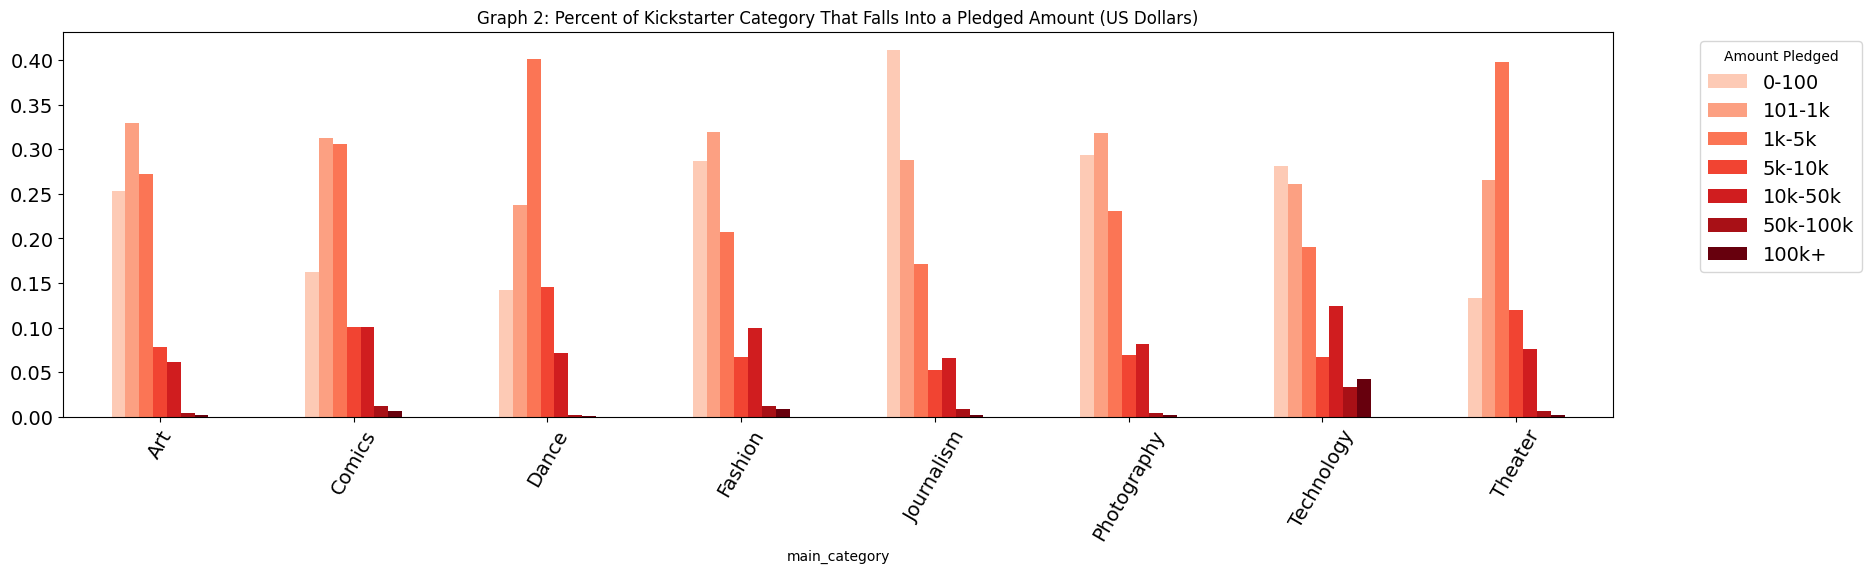

In [11]:
group_1 = df['main_category'].unique()[:7]  # First 7 groups
group_2 = df['main_category'].unique()[7:]  # Remaining 8 groups


df_group_1 = df[df['main_category'].isin(group_1)]
df_group_2 = df[df['main_category'].isin(group_2)]


#creating crosstabs
ct1 = pd.crosstab(df_group_1['main_category'], df_group_1['goal_bins'], normalize='index')
ct2 = pd.crosstab(df_group_2['main_category'], df_group_2['goal_bins'], normalize='index')


# creating color gradient for crosstab
cmap = plt.cm.Blues
start, end = 0.2, 1.0
colors = [cmap(start + (i / (len(ct1.columns) - 1)) * (end - start)) for i in range(len(ct1.columns))]


# Graph has several categories on the x-axis, therefore it is being split into two graphs, one with the first half and the other with the second
# First graph
ct1.plot.bar(figsize=(20,5), rot=60, color=colors, fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title="Goal Amount")
plt.title('Graph 1: Percent of Kickstarter Category That Falls Into a Goal Amount (US Dollars)');


# Second graph
ct2.plot.bar(figsize=(20,5), rot=60, color=colors, fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title="Goal Amount")
plt.title('Graph 2: Percent of Kickstarter Category That Falls Into a Goal Amount (US Dollars)');

# ----------------------------------------------------------------
# Repeating the above but for pledged amount rather than goal amount
# ----------------------------------------------------------------

# Creating Color gradient
cmap = plt.cm.Reds
colors = [cmap(start + (i / (len(ct1.columns) - 1)) * (end - start)) for i in range(len(ct1.columns))]

#creating crosstabs
ct1 = pd.crosstab(df_group_1['main_category'], df_group_1['pledged_bins'], normalize='index')
ct2 = pd.crosstab(df_group_2['main_category'], df_group_2['pledged_bins'], normalize='index')

# First graph
ct1.plot.bar(figsize=(20,5), rot=60, color=colors, fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title="Amount Pledged")
plt.title('Graph 1: Percent of Kickstarter Category That Falls Into a Pledged Amount (US Dollars)');


# Second graph
ct2.plot.bar(figsize=(20,5), rot=60, color=colors, fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title="Amount Pledged")
plt.title('Graph 2: Percent of Kickstarter Category That Falls Into a Pledged Amount (US Dollars)');
roup_1 = df['main_category'].unique()[:7]  # First 7 groups
group_2 = df['main_category'].unique()[7:]  # Remaining 8 groups

It can be seen how the funding a project requires compares to how much they receive. An interesting example is the Technology category. Generally the amount asked for is more than the amount received. Specifically most ask for between 10K and 50k, but most only receive between 0 and 100 dollars.

# Decision Tree

### preprocessing specific to decsion tree

In [12]:
label_encoder = LabelEncoder()

# Categorize pledge-to-goal ratio into buckets
df['goal_achievement_category'] = pd.cut(
    df['pledge_to_goal_ratio'],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0, float('inf')],
    labels=[0, 1, 2, 3, 4, 5]
)

# Encoding 
df['category'] = label_encoder.fit_transform(df['category'])
df['state'] = label_encoder.fit_transform(df['state'])
df['country'] = label_encoder.fit_transform(df['country'])

#drop
df = df.drop(columns=['main_category', 'pledged', 'pledge_to_goal_ratio', 'usd_ratio', 'success', 'usd pledged', 'currency', 'deadline', 'launched', 'name', 'pledged_bins', 'goal_bins', 'state'])
df = df.dropna()

# Check the processed DataFrame
print(df.head())

   category     goal  backers  country  length_of_fundraising_days  \
1        93  30000.0       15       22                          59   
2        93  45000.0        3       22                          44   
3        90   5000.0        1       22                          29   
4        55  19500.0       14       22                          55   
5       123  50000.0      224       22                          34   

  length_of_fund_bins goal_achievement_category  
1               41-60                         0  
2               41-60                         0  
3               21-40                         0  
4               41-60                         0  
5               21-40                         5  


In [13]:
# Separate features and target since we do not want data leakage
X = df.drop(columns=['goal_achievement_category', 'length_of_fund_bins'])
y = df['goal_achievement_category']  # Use the new target variable

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the decision tree
clf = DecisionTreeClassifier(random_state=42, max_depth=5)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

#baseline 
majority_class = pd.Series(y_train).value_counts().index[0]
baseline_acc= (majority_class == y_train).mean()
print(f'baseline accuracy: {baseline_acc:.3f}')

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f'Baseline Accuracy: {baseline_acc * 100:.2f}')

baseline accuracy: 0.465
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     30244
           1       0.00      0.00      0.00      4763
           2       0.00      0.00      0.00      1861
           3       0.00      0.00      0.00       766
           4       0.00      0.00      0.00      1013
           5       0.82      0.94      0.87     26567

    accuracy                           0.83     65214
   macro avg       0.28      0.32      0.30     65214
weighted avg       0.72      0.83      0.77     65214

Accuracy: 0.83
Baseline Accuracy: 46.47


c:\Users\anghe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anghe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anghe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

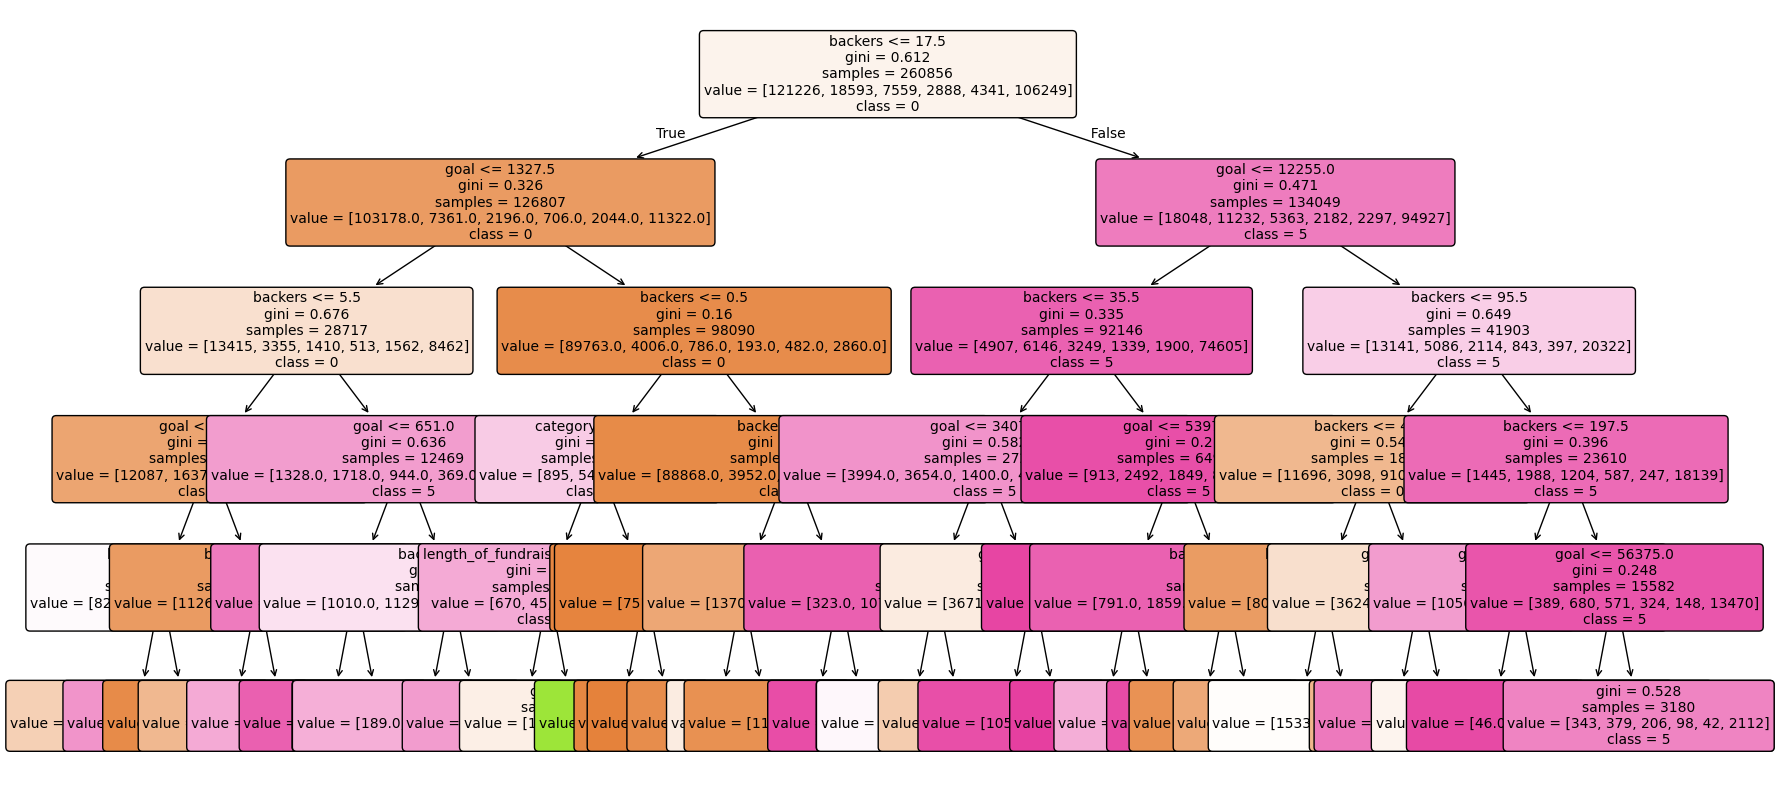

In [14]:
# Plot the decision tree
plt.figure(figsize=(20, 10))  # Set the figure size
plot_tree(
    clf,
    feature_names=list(X.columns),  # Use feature names
    class_names=clf.classes_.astype(str),  # Use class names 
    filled=True,  # Color nodes to represent class distribution
    rounded=True, 
    fontsize=10 
)
plt.show()

This decision tree provides insights into the factors that most influence the achievement of different levels of fundraising success. The first split, based on whether "success" is ≤ 0.5, highlights a clear distinction between lower-performing and higher-performing campaigns. Subsequent splits prioritize features such as the number of backers and the "usd_goal_real" value, indicating that smaller fundraising goals and a higher number of backers are critical predictors for achieving higher percentages of funding. On the right side of the tree, where "success" is higher, the model further refines predictions based on pledged amounts and backer counts, emphasizing their importance in classifying campaigns that achieve over 100% of their goal. Overall, the tree shows that backers and realistic goal-setting are the most decisive factors for success in crowdfunding campaigns.

### Conclusion: